<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV


plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv',na_filter=False)

In [3]:
# checking shape
house.shape

(1460, 81)

In [4]:
# building data dict
house_data_dict = {'Id':['Row number','fixed/mutable','cat/cont'],
                   'MSSubClass':['Identifies the type of dwelling involved in the sale', 'fixed', 'cat'],
                   'MSZoning':['Identifies the general zoning classification of the sale', 'fixed', 'cat'],
                   'LotFrontage':['Linear feet of street connected to property', 'fixed', 'cont'],
                   'LotArea':['Lot size in square feet', 'fixed', 'cont'],
                   'Street':['Type of road access to property', 'mutable', 'cat'],
                   'Alley':['Type of alley access to property', 'mutable', 'cat'], 
                   'LotShape':['General shape of property', 'fixed', 'cat'], 
                   'LandContour':['Flatness of the property', 'fixed', 'cat'], 
                   'Utilities':['Type of utilities available', 'mutable', 'cat'], 
                   'LotConfig':['Lot configuration', 'fixed', 'cat'],
                   'LandSlope':['Slope of property', 'fixed', 'cat'], 
                   'Neighborhood':['Physical locations within Ames city limits', 'fixed', 'cat'], 
                   'Condition1':['Proximity to various conditions', 'fixed', 'cat'], 
                   'Condition2':['Proximity to various conditions (if more than one is present)', 'fixed', 'cat'], 
                   'BldgType':['Type of dwelling', 'fixed', 'cat'],
                   'HouseStyle':['Style of dwelling', 'fixed', 'cat'], 
                   'OverallQual':['Rates the overall material and finish of the house', 'mutable', 'cont'], 
                   'OverallCond':['Rates the overall condition of the house','mutable', 'cont'], 
                   'YearBuilt':['Original construction date', 'fixed', 'cont'], 
                   'YearRemodAdd':['Remodel date (same as construction date if no remodeling or additions)',
                                   'fixed', 'cont'],
                   'RoofStyle':['Type of roof', 'fixed', 'cat'], 
                   'RoofMatl':['Roof material', 'mutable', 'cat'], 
                   'Exterior1st':['Exterior covering on house', 'mutable', 'cat'], 
                   'Exterior2nd':['Exterior covering on house (if more than one material)', 'mutable', 'cat'], 
                   'MasVnrType':['Masonry veneer type', 'mutable', 'cat'],
                   'MasVnrArea':['Masonry veneer area in square feet', 'mutable', 'cont'], 
                   'ExterQual':['Evaluates the quality of the material on the exterior', 'mutable', 'cat'], 
                   'ExterCond':['Evaluates the present condition of the material on the exterior', 'mutable', 'cat'], 
                   'Foundation':['Type of foundation', 'fixed', 'cat'], 
                   'BsmtQual':['Evaluates the height of the basement', 'mutable', 'cat'],
                   'BsmtCond':['Evaluates the general condition of the basement', 'mutable', 'cat'], 
                   'BsmtExposure':['Refers to walkout or garden level walls', 'fixed', 'cat'], 
                   'BsmtFinType1':['Rating of basement finished area', 'mutable', 'cat'], 
                   'BsmtFinSF1':['Type 1 finished square feet', 'fixed', 'cont'],
                   'BsmtFinType2':['Rating of basement finished area (if multiple types)', 'mutable', 'cat'], 
                   'BsmtFinSF2':['Type 2 finished square feet', 'fixed', 'cont'], 
                   'BsmtUnfSF':['Unfinished square feet of basement area', 'fixed', 'cont'], 
                   'TotalBsmtSF':['Total square feet of basement area', 'fixed', 'cont'], 
                   'Heating':['Type of heating', 'mutable', 'cat'],
                   'HeatingQC':['Heating quality and condition', 'mutable', 'cat'], 
                   'CentralAir':['Central air conditioning', 'mutable', 'bin'], 
                   'Electrical':['Electrical system', 'mutable', 'cat'], 
                   '1stFlrSF':['First Floor square feet','fixed', 'cont'], 
                   '2ndFlrSF':['Second floor square feet','fixed', 'cont'],
                   'LowQualFinSF':['Low quality finished square feet (all floors)', 'mutable', 'cont'], 
                   'GrLivArea':['Above grade (ground) living area square feet', 'fixed', 'cont'], 
                   'BsmtFullBath':['Basement full bathrooms', 'mutable', 'cont'], 
                   'BsmtHalfBath':['Basement half bathrooms', 'mutable', 'cont'], 
                   'FullBath':['Full bathrooms above grade', 'mutable', 'cont'],
                   'HalfBath':['Half baths above grade', 'mutable', 'cont'], 
                   'BedroomAbvGr':['Bedrooms above grade (does NOT include basement bedrooms)', 'mutable', 'cont'], 
                   'KitchenAbvGr':['Kitchens above grade', 'mutable', 'cont'], 
                   'KitchenQual':['Kitchen quality', 'mutable', 'cat'],
                   'TotRmsAbvGrd':['Total rooms above grade (does not include bathrooms)', 'fixed', 'cont'], 
                   'Functional':['Home functionality (Assume typical unless deductions are warranted)',
                                 'mutable', 'cat'], 
                   'Fireplaces':['Number of fireplaces', 'fixed', 'cont'], 
                   'FireplaceQu':['Fireplace quality', 'mutable', 'cat'], 
                   'GarageType':['Garage location','fixed','cat'],
                   'GarageYrBlt':['Year garage was built','fixed','cont'], 
                   'GarageFinish':['Interior finish of the garage','mutable','cat'], 
                   'GarageCars':['Size of garage in car capacity','fixed','cont'], 
                   'GarageArea':['Size of garage in square feet','fixed','cont'], 
                   'GarageQual':['Garage quality','mutable','cat'],
                   'GarageCond':['Garage condition','mutable','cat'], 
                   'PavedDrive':['Paved driveway','mutable','cat'], 
                   'WoodDeckSF':['Wood deck area in square feet','fixed','cont'], 
                   'OpenPorchSF':['Open porch area in square feet','fixed','cont'],
                   'EnclosedPorch':['Enclosed porch area in square feet','fixed','cont'], 
                   '3SsnPorch':['Three season porch area in square feet','fixed','cont'], 
                   'ScreenPorch':['Screen porch area in square feet','fixed','cont'], 
                   'PoolArea':['Pool area in square feet','fixed','cont'], 
                   'PoolQC':['Pool quality','mutable','cat'],
                   'Fence':['Fence quality','mutable','cat'], 
                   'MiscFeature':['Miscellaneous feature not covered in other categories','fixed','cat'], 
                   'MiscVal':['$Value of miscellaneous feature','fixed','cont'], 
                   'MoSold':['Month Sold (MM)','fixed','cat'], 
                   'YrSold':['Year Sold (YYYY)','fixed','cont'], 
                   'SaleType':['Type of sale','fixed','cat'],
                   'SaleCondition':['Condition of sale','fixed','cat'], 
                   'SalePrice':['Value of property at sale','fixed','cont']}

## Cleaning data 

In [5]:
# checking for duplicate rows, none found
house.duplicated().sum()

0

In [6]:
# dropping rows with non residential properties
house = house[house['MSZoning'] != 'C (all)']
house = house[house['MSZoning'] !='FV']
house.shape

(1385, 81)

In [7]:
# splitting vars into continuous and catergoricals
cont_vars = []
cat_vars = []
for k,v in house_data_dict.items():
    if v[2] == 'cont':
        cont_vars.append(k)
    elif v[2] == 'cat':
        cat_vars.append(k)

### Continuous variables

In [8]:
print(cont_vars)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']


**Datatypes & missing values**

All continuous variables should be encoded as ints/floats. .dtypes shows LotFrontage, MasVnrArea, GarageYrBlt are all encoded as objects. This is because these columns contain missing values which are formatted as 'NA'. I've changed those missing values to np.nans and changed the column dtypes to floats. 

As so there are so many missing values for LotFrontage, I don't want to drop rows with missing values. It also seems too coarse to impute a single value for all 251 rows of LotFrontage. Instead, I'm going to impute all missing values in cont_vars using a multivariate imputer (KNNImputer). 

In [9]:
# checking continuous vars dtypes
house[cont_vars].dtypes

# LotFrontage, MasVnrArea, GarageYrBlt are all encoded as objects. All others are ints.
# cols encoded as objects have missing values. Specificaly:

# 251 rows have missing LotFrontage values ('NA')
len(house[house['LotFrontage']=='NA'])
# converting to float
house.loc[house['LotFrontage'] == 'NA', 'LotFrontage'] = np.nan
house['LotFrontage'] = house['LotFrontage'].astype(float)

# 5 rows have missing MasVnrArea values ('NA')
len(house[house['MasVnrArea']=='NA'])
# converting to float
house.loc[house['MasVnrArea'] == 'NA', 'MasVnrArea'] = np.nan
house['MasVnrArea'] = house['MasVnrArea'].astype(float)

# 79 rows have missing GarageYrBlt vales ('NA')
len(house[house['GarageYrBlt']=='NA'])
# converting to float
house.loc[house['GarageYrBlt'] == 'NA', 'GarageYrBlt'] = np.nan
house['GarageYrBlt'] = house['GarageYrBlt'].astype(float)

In [10]:
# getting cont_vars without target for imputation 
X_cont_vars = cont_vars[:-1]

# checking descriptives pre-imputation
house[['LotFrontage','MasVnrArea','GarageYrBlt']].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1134.000000,1380.000000,1306.000000
mean,70.583774,102.768841,1977.336141
std,24.251032,174.373232,24.477677
min,21.000000,0.000000,1906.000000
25%,60.000000,0.000000,1960.000000
50%,70.000000,0.000000,1978.000000
75%,80.000000,168.000000,2000.000000
max,313.000000,1378.000000,2010.000000


In [11]:
from sklearn.impute import KNNImputer 

# imputing missing values
kknImp = KNNImputer()
house[X_cont_vars] =  kknImp.fit_transform(house[X_cont_vars])

# checking descriptives post-imputation. Nothing radically different.
house[['LotFrontage','MasVnrArea','GarageYrBlt']].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1385.000000,1385.000000,1385.000000
mean,71.569386,103.092996,1976.452996
std,23.591979,174.552362,24.326146
min,21.000000,0.000000,1906.000000
25%,60.000000,0.000000,1959.800000
50%,70.000000,0.000000,1977.000000
75%,81.800000,168.000000,2000.000000
max,313.000000,1378.000000,2010.000000


**Continuous variables boxplot (below)**

The boxplot below shows the z-scaled distributions of the continuous variables./

A small number of the continuous variables appear to have roughly normal distributions. Many of these are either ordinal variables (e.g. OverallQual or Overallcond) or interval variables (e.g. BedroomAbvrGR). 

An even smaller number have a slight left/negative skew. Specifically, these are YearBuilt and GarageYrBlt). This indicates that the buildings in the data set tend to be more recently constructed. 

The majority of the remaining variables have a strong right/positive skew. Given that the dataset is about housing, this is not particularly surprising or suspicisous. However, there are some individual records which are so far beyond the main distribution that it seems likely that these may be errors (e.g. the greatest LotArea value is almost 5 standard deviations greater than the 2nd greatest and 20 greater than the mean). These values should be removed. Because most of the right skewed variables many have values well beyond IQR * 1.5, it is not practical to use IQR outlier detection. Instead, I will remove values more than 10 stds from the mean. This value was selected as the plot indicates this should remove the most extreme outliers without impacting the main distribution of the variables. This will also leave the target variable intact.

Before removing these outliers, there are some variables with unusual distributions that need individual attention. These are addressesed below.

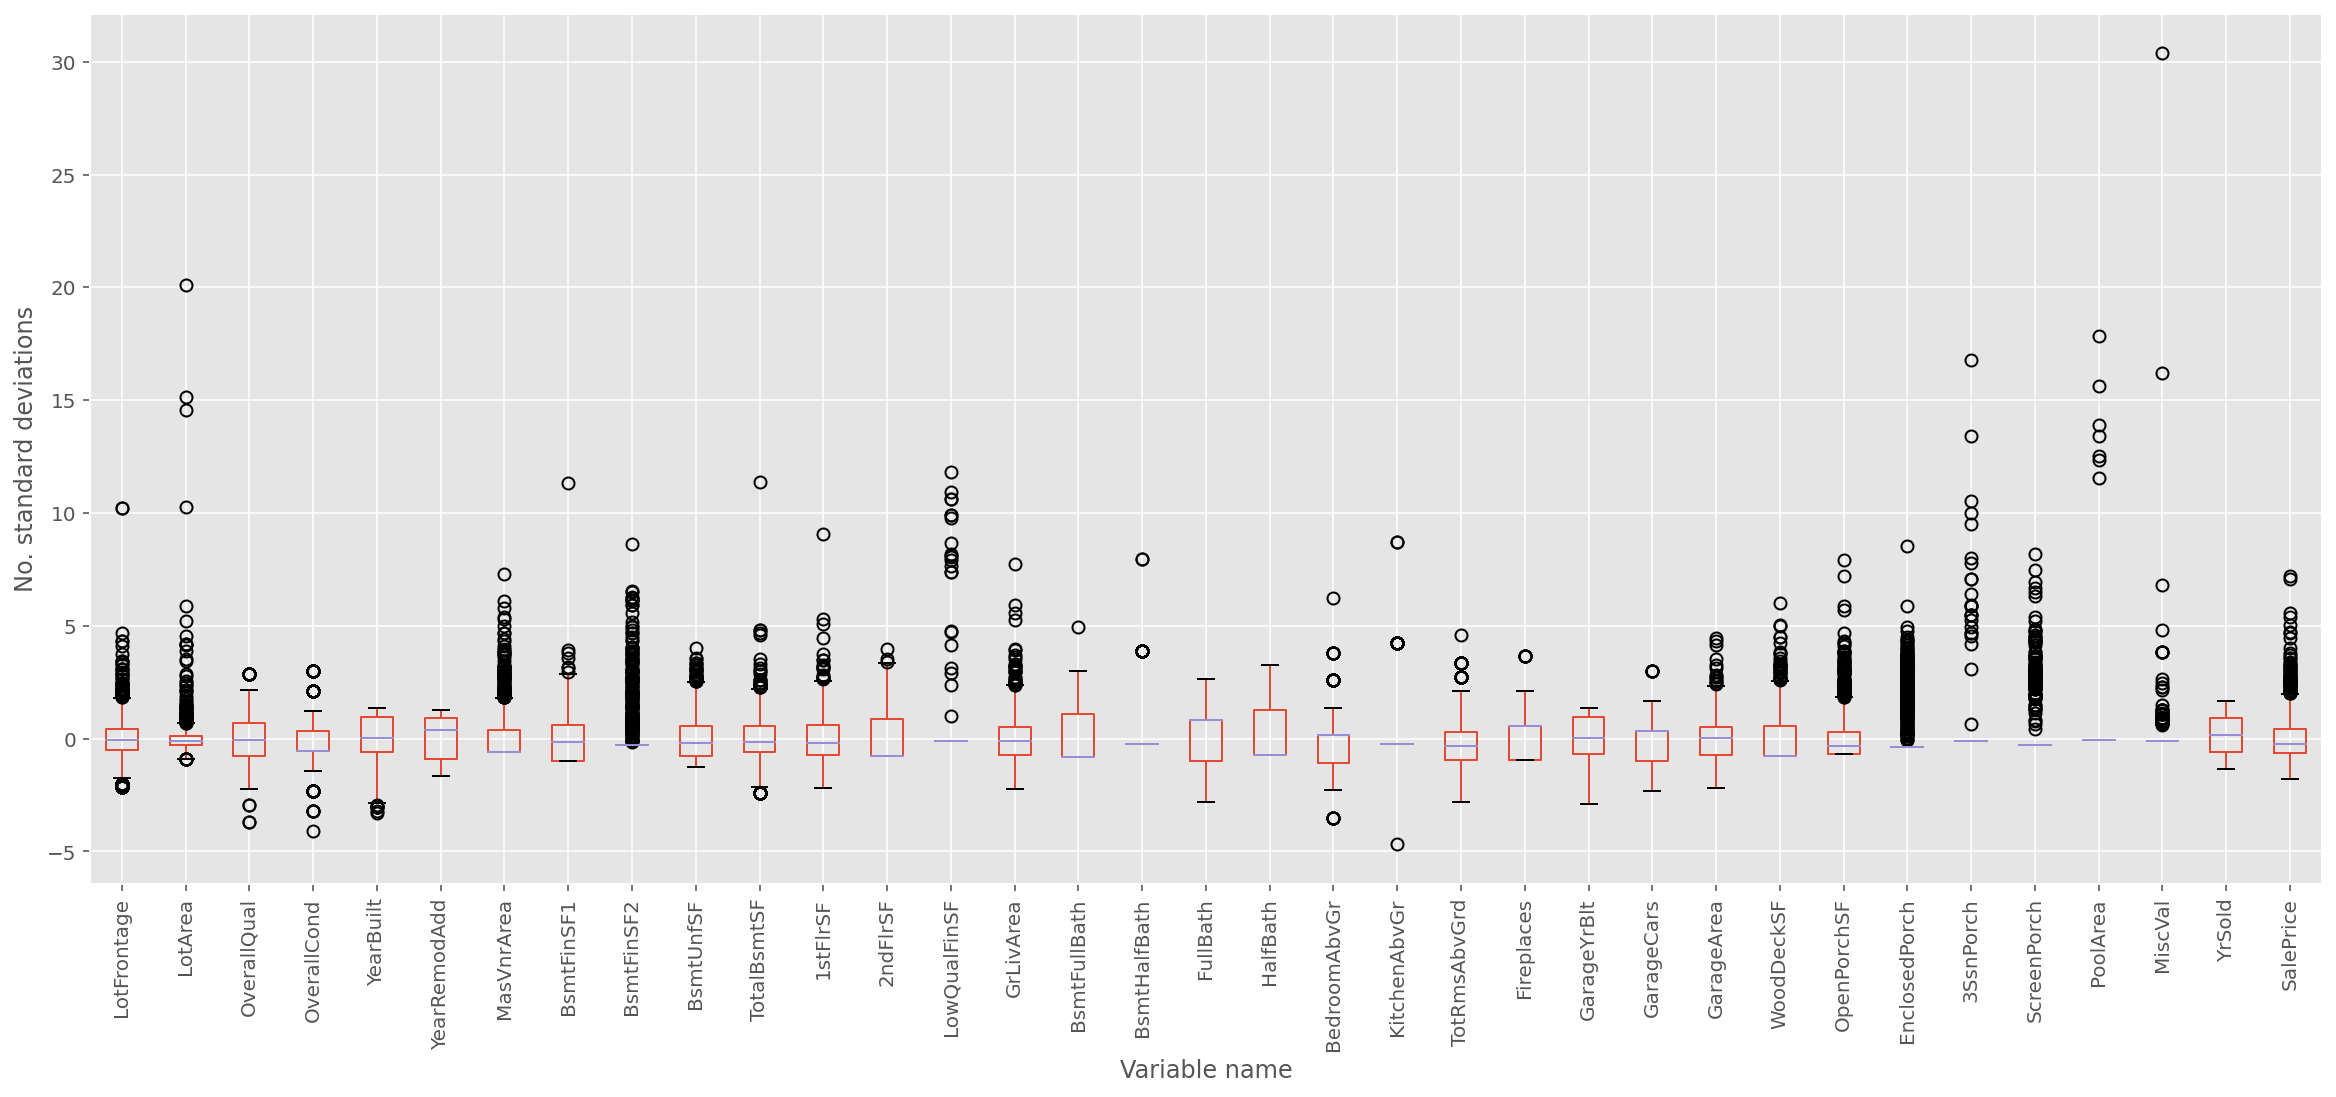

In [12]:
# looking at the distributions of the continous variables to check for outliers
# using standardised values for easier visualization
from sklearn.preprocessing import StandardScaler
sscaler = StandardScaler()

fig, ax = plt.subplots(figsize=[20,8]);
pd.DataFrame(sscaler.fit_transform(house[cont_vars]),columns=house[cont_vars].columns).boxplot();
plt.xticks(rotation=90);
plt.xlabel('Variable name');
plt.ylabel('No. standard deviations');

**LowQualFinSF** - Low quality finished square feet (all floors).

Above plot shows LowQualFinSF's percentiles are all equal, but there are a number of (IQR method) outliers. Checking value counts to see why.

Value counts shows there are only 22 non-zero values. As such, I will convert the column to a binary variable.
New var is called 'HasLowQualFin'.

In [13]:
# checking value counts
house['LowQualFinSF'].value_counts()

# adding 'HasLowQualFin' to data & data dict
house['HasLowQualFin'] = [int(not elem) for elem in house['LowQualFinSF'] == False]
house_data_dict['HasLowQualFin'] = ['Any amount of low quality finished floors? (all floors)', 'mutable', 'cat']
cat_vars.append('HasLowQualFin')

# removing old var from data & data dict
del house['LowQualFinSF']
del house_data_dict['LowQualFinSF']
cont_vars.remove('LowQualFinSF')

**BsmtFinSF2** - Type 2 finished square feet.

Similarly to LowQualFinSF, BsmtFinSF2's unusual boxplot is due to the majority of BsmtFinSF2 values being zero (the non-zero values make up 12% of the dataset). This is because most properties only have either a basement with a single finish or no basement whatsoever. 

Unlike LowQualFinSF, BsmtFinSF2 cannot be easily converted to a binary variable as it is likely that it's relationship with SalePrice is dependent on BsmtFinType2. E.g. a large BsmtFinSF2 value with a 'Good Living Quarters' value for BsmtFinType2 is likely to increase SalePrice, where as a large BsmtFinSF2 value with a 'Low Quality' value for BsmtFinType2 is likely to have the inverse effect. 

As such, I will leave these values as they are for now. Later on, I will create polynomial variables for the interactions between the two basement type variables (BsmtFinType1, BsmtFinType2) and their corresponding basement finish area variables (BsmtFinSF1, BsmtFinSF2). 

In [14]:
# updating BsmtFinType1 & BsmtFinType2's values for easier reading
bsmt_fin_types = {'GLQ':'Good Living Quarters', 
                  'ALQ':'Average Living Quarters', 
                  'BLQ': 'Below Average Living Quarters',
                  'Rec':'Average Rec Room',
                  'LwQ':'Low Quality',
                  'Unf':'Unfinshed',
                  'NA':'No Basement'}

house['BsmtFinType1'] = [bsmt_fin_types[i] for i in house['BsmtFinType1']]
house['BsmtFinType2'] = [bsmt_fin_types[i] for i in house['BsmtFinType2']]

# getting % of non-zero BsmtFinSF2 values in dataset
len(house.loc[house['BsmtFinSF2'] > 0, 'BsmtFinSF1'])/len(house)

# looking at range of non-zero BsmtFinSF2 values
house.loc[house['BsmtFinSF2'] > 0, 'BsmtFinSF1'].describe()

# looking at the relationship between BsmtFinSF2, BsmtFinType2 and SalePrice
house.groupby('BsmtFinType2')[['BsmtFinSF2','SalePrice']].corr()

BsmtFinSF2  SalePrice
BsmtFinType2                                                   
Average Living Quarters       BsmtFinSF2    1.000000   0.031682
                              SalePrice     0.031682   1.000000
Average Rec Room              BsmtFinSF2    1.000000   0.026968
                              SalePrice     0.026968   1.000000
Below Average Living Quarters BsmtFinSF2    1.000000   0.218463
                              SalePrice     0.218463   1.000000
Good Living Quarters          BsmtFinSF2    1.000000   0.598744
                              SalePrice     0.598744   1.000000
Low Quality                   BsmtFinSF2    1.000000   0.028890
                              SalePrice     0.028890   1.000000
No Basement                   BsmtFinSF2    1.000000   0.707735
                              SalePrice     0.707735   1.000000
Unfinshed                     BsmtFinSF2         NaN        NaN
                              SalePrice          NaN   1.000000

**BsmtHalfBath, KitchenAbvGr**

Again, the boxplots for BsmtHalfBath and KitchenAbvGr are completely flat (with some outliers) as the vast majority of the values are 0 and 1, respectively. Will investigate creating an interaction term between KitchenAbvGr and KitchenQual. Nothing else note worthy and no futher cleaning needed here.

In [15]:
house['BsmtHalfBath'].value_counts()

0.0    1304
1.0      79
2.0       2
Name: BsmtHalfBath, dtype: int64

In [16]:
house['KitchenAbvGr'].value_counts()

1.0    1318
2.0      64
3.0       2
0.0       1
Name: KitchenAbvGr, dtype: int64

**PoolArea**

Only 7 properties have a pool, hence the flat PoolArea boxplot. As with BsmtFinSF1/2, the contribution of PoolArea to the property's SalePrice is likely to be dependent on it's quality (PoolQC). I have looked at this relationship below, but there are too few records to draw any meaningful conclusions. As such, I will remove PoolArea and PoolQC from the dataset.

In [17]:
# checking number of non-zero PoolArea values
len(house[house['PoolArea']!=0])

# checking number of non-zero PoolArea values per PoolQC level
house['PoolQC'].value_counts()

# checking relationship between PoolQC, PoolArea & SalePrice
house.groupby('PoolQC')[['PoolArea','SalePrice']].corr()

# removing PoolArea and PoolQC from the dataset, data_dict
house.drop(columns=['PoolArea','PoolQC'],axis=1, inplace = True)
del house_data_dict['PoolArea']
del house_data_dict['PoolQC']
cont_vars.remove('PoolArea')
cat_vars.remove('PoolQC')

**MiscVal**

MiscVal also has a flat boxplot, with many outliers. This is becuase there are only 47 properties with a MiscFeature and MiscVal. No cleaining is needed here, but I will create interaction terms between MiscFeature and MiscVal later on.

In [18]:
# checking num of MiscVal records, 47
house.groupby('MiscFeature')['MiscVal'].count()

# checking mean value associated with the MiscFeature levels
house.groupby('MiscFeature')['MiscVal'].mean()

MiscFeature
Gar2    11900.000000
NA          0.000000
Othr     1750.000000
Shed      714.468085
TenC     2000.000000
Name: MiscVal, dtype: float64

**3SsnPorch, ScreenPorch**

3SsnPorch and ScreenPorch are the final two continuous features with flat boxplots. Again, this is because the majority of properties do not have 3 season porches or screen porches (only 24 and 114, respectively). As before, it appears no additional cleaning is needed here. However, I have experimented with creating some new features based on the various porch variables (3SsnPorch, OpenPorchSF, ScreenPorch and EnclosedPorch). These are:
* TotalPorchSF - the sum of all porch variables in each row (i.e. total area).
* Has3SsnPorch, HasOpenPorchSF, HasScreenPorch, HasEnclosedPorch - binary variables encoding whether a house has any of the various types of porches (as opposed to it's area).
* Amount3SsnPorch, AmountOpenPorchSF, AmountScreenPorch and AmountEnclosedPorch - the porportion of the overall porch area occupied by each porch type.

In the cell beneath the one in which these were created, I have looked at the correlation between these variables and the target. Some of the new variables are more correlated with the target than those they were derived from. Others are less correlated. Naturally, these variables have a significant amount of colinearity. Rather than manually selecting amongst them, I will use regularization to allow the model to perform automatic feature selection.

In [19]:
len(house[house['3SsnPorch']!=0]) # 24

len(house[house['ScreenPorch']!=0]) # 114

# creating total porch area variable
house['TotalPorchSF'] = house[['3SsnPorch','OpenPorchSF','ScreenPorch','EnclosedPorch']].sum(axis=1)

# creating binary variables 
house['Has3SsnPorch'] = [int(not elem) for elem in house['3SsnPorch'] == False]
house['HasOpenPorchSF'] = [int(not elem) for elem in house['OpenPorchSF'] == False]
house['HasScreenPorch'] = [int(not elem) for elem in house['ScreenPorch'] == False]
house['HasEnclosedPorch'] = [int(not elem) for elem in house['EnclosedPorch'] == False]

# creating amount variables
house['Amount3SsnPorch'] = house['3SsnPorch']/house['TotalPorchSF']
house['Amount3SsnPorch'].fillna(0.0) # cleaning NaNs created by zero division

house['AmountOpenPorchSF'] = house['OpenPorchSF']/house['TotalPorchSF']
house['AmountOpenPorchSF'].fillna(0.0)

house['AmountScreenPorch'] = house['ScreenPorch']/house['TotalPorchSF']
house['AmountScreenPorch'].fillna(0.0)

house['AmountEnclosedPorch'] = house['EnclosedPorch']/house['TotalPorchSF']
house['AmountEnclosedPorch'].fillna(0.0)

# adding new variables to data_dict, cont_vars, cat_vars
house_data_dict['Has3SsnPorch'] = ['Identifies if property has a 3 season porch', 'mutable', 'cat']
house_data_dict['Amount3SsnPorch'] = ['3 season porch amount as % of overall porch area', 'mutable', 'cont']
house_data_dict['HasOpenPorchSF'] = ['Identifies if property has an open porch', 'mutable', 'cat']
house_data_dict['AmountOpenPorchSF'] = ['open porch amount as % of overall porch area', 'mutable', 'cont']
house_data_dict['HasScreenPorch'] = ['Identifies if property has a screen porch', 'mutable', 'cat']
house_data_dict['AmountScreenPorch'] = ['screen amount as % of overall porch area', 'mutable', 'cont']
house_data_dict['HasEnclosedPorch'] = ['Identifies if property has an enclosed porch', 'mutable', 'cat']
house_data_dict['AmountEnclosedPorch'] = ['enclosed porch amount as % of overall porch area', 'mutable', 'cont']
house_data_dict['TotalPorchSF'] = ['Total porch area', 'mutable', 'cont']

# re-splitting vars into continuous and catergoricals
cont_vars = []
cat_vars = []
for k,v in house_data_dict.items():
    if v[2] == 'cont':
        cont_vars.append(k)
    elif v[2] == 'cat':
        cat_vars.append(k)

TotalPorchSF           0.203290
3SsnPorch              0.046701
Has3SsnPorch           0.048297
Amount3SsnPorch        0.015248
OpenPorchSF            0.324483
HasOpenPorchSF         0.411544
AmountOpenPorchSF      0.261752
ScreenPorch            0.116110
HasScreenPorch         0.092449
AmountScreenPorch      0.013135
EnclosedPorch         -0.115892
HasEnclosedPorch      -0.169703
AmountEnclosedPorch   -0.317203
SalePrice              1.000000
Name: SalePrice, dtype: float64

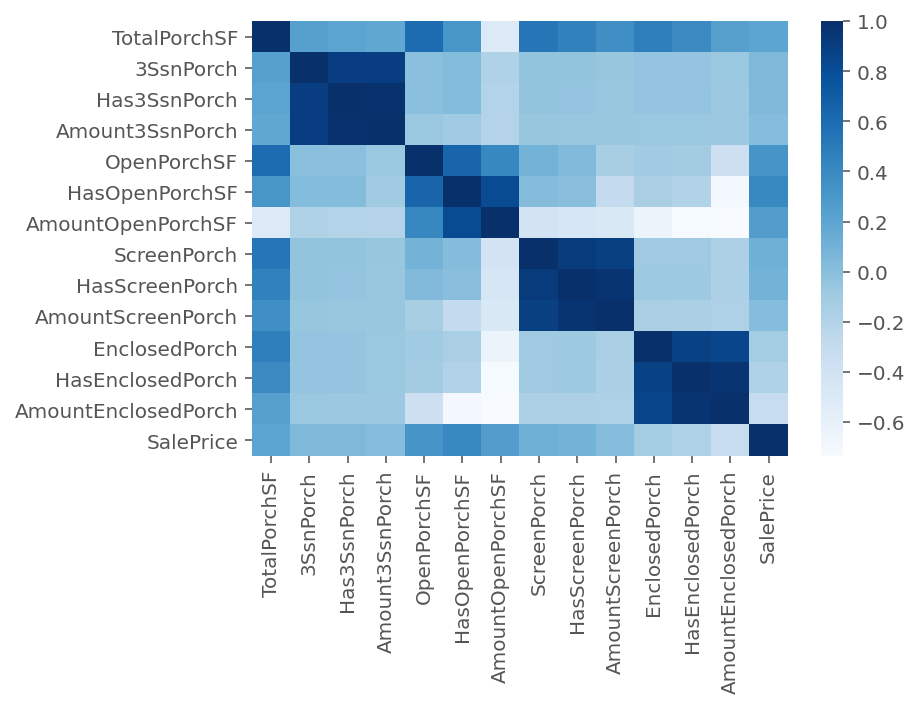

In [20]:
# heatmapping the correlations amongst the porch variables and with the target
sns.heatmap(house[['TotalPorchSF',
       '3SsnPorch', 'Has3SsnPorch', 'Amount3SsnPorch',
       'OpenPorchSF', 'HasOpenPorchSF', 'AmountOpenPorchSF',
       'ScreenPorch', 'HasScreenPorch', 'AmountScreenPorch',
       'EnclosedPorch', 'HasEnclosedPorch', 'AmountEnclosedPorch',
       'SalePrice']].corr(),cmap='Blues')

# getting the correlation coefficients between the porch variables and the target 
house[['TotalPorchSF',
       '3SsnPorch', 'Has3SsnPorch', 'Amount3SsnPorch',
       'OpenPorchSF', 'HasOpenPorchSF', 'AmountOpenPorchSF',
       'ScreenPorch', 'HasScreenPorch', 'AmountScreenPorch',
       'EnclosedPorch', 'HasEnclosedPorch', 'AmountEnclosedPorch',
       'SalePrice']].corr().iloc[-1]

**Dropping outliers**

As discussed above, I'm going to drop any values 10 stds beyond the mean. When doing this, I will exclude the variables with a flat boxplot whose mode is 0. This is because, a property with, for instace, MiscVal == 0 indicates the property has no MiscFeature. As such the 'true' ditributions would be the ditributions without the properties who dont have the feature in question. These distributions do not include values beyond 10 stds of the mean. Specifically, these are BsmtFinsf2, MiscVal 3SsnPorch and ScreenPorch.

In [21]:
print(house.shape)

# setting aside vars 
for el in ['BsmtFinSF2', 'MiscVal', '3SsnPorch', 'ScreenPorch']:
    cont_vars.remove(el)

# removing outliers
for col in cont_vars:
    mean = house[col].mean()
    std = house[col].std()
    
    # dropping rows with values <= to mean + 10 x std
    house = house[(house[col] <= mean+(10*std))]
    # no need to drop rows with values below 10 stds, as no values are below 10 stds

# adding set aside vars back in
for el in ['BsmtFinSF2', 'MiscVal', '3SsnPorch', 'ScreenPorch']:
    cont_vars.append(el)
    
print(house.shape) # not very happy with the number of rows this has dropped

(1385, 88)
(931, 88)


### Catergorical variables

**Dtypes and missing values**

In [22]:
house[cat_vars].dtypes

MSSubClass           int64
MSZoning            object
Street              object
Alley               object
LotShape            object
LandContour         object
Utilities           object
LotConfig           object
LandSlope           object
Neighborhood        object
Condition1          object
Condition2          object
BldgType            object
HouseStyle          object
RoofStyle           object
RoofMatl            object
Exterior1st         object
Exterior2nd         object
MasVnrType          object
ExterQual           object
ExterCond           object
Foundation          object
BsmtQual            object
BsmtCond            object
BsmtExposure        object
BsmtFinType1        object
BsmtFinType2        object
Heating             object
HeatingQC           object
Electrical          object
KitchenQual         object
Functional          object
FireplaceQu         object
GarageType          object
GarageFinish        object
GarageQual          object
GarageCond          object
P

MSSubClass uses numerical codes to identify the type of dwelling involved in the sale. I've converted these values to the code descriptions (i.e. strs) for readability and so that it is not treated as a continuous variable.

In [23]:
MSSubClass_levels = {20:'1-STORY 1946 & NEWER ALL STYLES',
        30:'1-STORY 1945 & OLDER',
        40:'1-STORY W/FINISHED ATTIC ALL AGES',
        45:'1-1/2 STORY - UNFINISHED ALL AGES',
        50:'1-1/2 STORY FINISHED ALL AGES',
        60:'2-STORY 1946 & NEWER',
        70:'2-STORY 1945 & OLDER',
        75:'2-1/2 STORY ALL AGES',
        80:'SPLIT OR MULTI-LEVEL',
        85:'SPLIT FOYER',
        90:'DUPLEX - ALL STYLES AND AGES',
       120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
       150:'1-1/2 STORY PUD - ALL AGES',
       160:'2-STORY PUD - 1946 & NEWER',
       180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
       190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}

house['MSSubClass'] = [MSSubClass_levels[i] for i in house['MSSubClass']]
house['MSSubClass'].value_counts()

1-STORY 1946 & NEWER ALL STYLES                          326
2-STORY 1946 & NEWER                                     246
1-1/2 STORY FINISHED ALL AGES                             94
1-STORY PUD (Planned Unit Development) - 1946 & NEWER     65
1-STORY 1945 & OLDER                                      45
2-STORY 1945 & OLDER                                      44
SPLIT OR MULTI-LEVEL                                      28
2 FAMILY CONVERSION - ALL STYLES AND AGES                 17
2-STORY PUD - 1946 & NEWER                                17
2-1/2 STORY ALL AGES                                      15
DUPLEX - ALL STYLES AND AGES                              10
SPLIT FOYER                                                9
1-1/2 STORY - UNFINISHED ALL AGES                          8
PUD - MULTILEVEL - INCL SPLIT LEV/FOYER                    5
1-STORY W/FINISHED ATTIC ALL AGES                          2
Name: MSSubClass, dtype: int64

MoSold (month sold) is encoded as ints, but would be better treated as a catergorical. However, both MoSold and YrSold are properties of the sale, rather than properties of the house. As such, they can't be used as predictors in any of the exercises. I will drop MoSold from the data, but need to keep year sold in order to split the data into a training and test set.

In [24]:
house.drop(columns='MoSold',axis=1, inplace= True) 
del house_data_dict['MoSold']
cat_vars.remove('MoSold')

All other numerically encoded catergorical variables are binary variables. No further changes to dtypes are requied.

Next, finding and cleaning missing values. Throughout the dataset 'NA' is used to indicate missing values. However, in some columns, it is also used to indicate that a property does not have a particular feature (e.g. in Fence, 'NA' means the property has no fence, not that the value is missing). 

This means that some columns include two different kinds of information- 1) whether a property has a particular feature and 2) if it does, what the quality of that feature is. To parse this information out it will be necessary to create a new column specifying whether the property has the feature, and another specifying the quality of that feature if present. This will allow me to keep the ranked order of the quality variables, and to convert them into numerical variables. By standardising these and creating an interaction term between the two columns it will be possible to zero-out the quality variables 

In [25]:
for var in cat_vars:
    if 'NA' in house[var].unique():
        print(f'{var} has {house[var].value_counts()["NA"]} NA values.')
        print(house[var].unique(), '\n')

Alley has 876 NA values.
['NA' 'Grvl' 'Pave'] 

MasVnrType has 5 NA values.
['BrkFace' 'None' 'Stone' 'BrkCmn' 'NA'] 

BsmtQual has 11 NA values.
['Gd' 'TA' 'Ex' 'Fa' 'NA'] 

BsmtCond has 11 NA values.
['TA' 'Gd' 'Fa' 'NA'] 

BsmtExposure has 12 NA values.
['No' 'Mn' 'Av' 'Gd' 'NA'] 

FireplaceQu has 359 NA values.
['NA' 'TA' 'Gd' 'Fa' 'Ex' 'Po'] 

GarageType has 39 NA values.
['Attchd' 'Detchd' 'BuiltIn' 'NA' 'Basment' '2Types' 'CarPort'] 

GarageFinish has 39 NA values.
['RFn' 'Unf' 'Fin' 'NA'] 

GarageQual has 39 NA values.
['TA' 'Fa' 'Gd' 'NA' 'Ex' 'Po'] 

GarageCond has 39 NA values.
['TA' 'NA' 'Fa' 'Po' 'Ex' 'Gd'] 

Fence has 767 NA values.
['NA' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw'] 

MiscFeature has 901 NA values.
['NA' 'Shed' 'Othr' 'Gar2' 'TenC'] 



<ipython-input-25-6793f95076a8>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'NA' in house[var].unique():


In Alley, 'NA' means no alley access. As such, Alley can simply be one hot encoded such that there are two columns specifying whether the propert has gravel alley access or paved alley access (or neither). I'll do this later when one hot encoding the rest.

In MasVnrType 'None' indicates that the property does not have masonary veneer, whereas 'NA' indicates a missing value. As there are only 5 missing values, I will drop these (see below).

In MiscFeature, 'NA' indicates that the property does not have a miscellaneous feature. As this is not a ranked variable it will need to be one hot encoded (rather than converted to a numeric). I'll then create interactions with MiscVal.

For GarageType and GarageFinish, 'NA' indicates that the property does not have a garage. GarageType can be one hot encoded (with 0's in all columns indicating that the building does not have a garage). GarageFinish can be interpreted as a ranked variable (i.e. extent of finish - unfinished, partially finsihed, completely finished). Below, I've checked the mean and median SalePrices associated with each level, and they support this ranking. As such, I will convert this to a continuous variable. 

In Fence, 'NA' means that the property does not have a fence. However the other values in this column mean that it will need to be handled independently. Specifically, it has 4 other levels. 2 of these rate the amount of privacy that the fence affords. The other two describe the material that the fence is made from. This is problematic, as it means that if have property does have a fence, we can only know about its material or privacy rating. Furthermore, I do not feel that there is sufficient data to reliably impute the missing material and privacy values. For this reason, I've decided to convert this into a binary value indicating whether or not the property has a fence and otherwise to drop the original column.

In the remaining variables listed above 'NA' indicates that the building does not have that feature. These will get the treament described in the previous Markdown cell.

In [26]:
# dropping 5 rows with missing values for MasVnrType

print(house.shape)
house = house[house['MasVnrType']!='NA']
print(house.shape)

(931, 87)
(926, 87)


In [27]:
# creating binary variables for basement, fireplace, garage & fence

house['HasBsmt'] = [int(el == 'NA') for el in house['BsmtQual']]
house['HasFireplace'] = [int(el == 'NA') for el in house['FireplaceQu']]
house['HasGarage'] = [int(el == 'NA') for el in house['GarageQual']]
house['HasFence'] = [int(el == 'NA') for el in house['Fence']]

# adding new variables to data dict & cat_vars
house_data_dict['HasBsmt'] = ['Indicates if the property has a basement', 'fixed', 'cat']
house_data_dict['HasFireplace'] = ['Indicates if the property has a fireplace', 'fixed', 'cat']
house_data_dict['HasGarage'] = ['Indicates if the property has a garage', 'fixed', 'cat']
house_data_dict['HasFence'] = ['Indicates if the property has a fence', 'mutable', 'cat']

cont_vars = []
cat_vars = []
for k,v in house_data_dict.items():
    if v[2] == 'cont':
        cont_vars.append(k)
    elif v[2] == 'cat':
        cat_vars.append(k)

In [28]:
# dropping the fence col
house.drop(columns='Fence', axis =1, inplace= True)
del house_data_dict['Fence']

cont_vars = []
cat_vars = []
for k,v in house_data_dict.items():
    if v[2] == 'cont':
        cont_vars.append(k)
    elif v[2] == 'cat':
        cat_vars.append(k)

In [29]:
# converting the quality/condition variables & BsmtExposure to numerics
quality_feats = ['ExterQual',
                'ExterCond',
                'BsmtQual',
                'BsmtCond',
                'HeatingQC',
                'KitchenQual',
                'FireplaceQu',
                'GarageQual',
                'GarageCond'
                ]

# checking values pre conversion
print('BsmtExposure', house['BsmtExposure'].unique())
for var in quality_feats:
    print(var, house[var].unique())

# dict to convert values
qual_to_num = {'Ex':5,  # Excellent
               'Gd':4,  # Good
               'TA':3,  # Typical/Average
               'Fa':2,  # Fair
               'Po':1,  # Poor
               'NA':0   # feature not present
              }

# dict to convert BsmtExposure
BsmtExposure_levels = {'Gd':4,  # Good Exposure
                       'Av':3,  # Average Exposure (split levels or foyers typically score average or above)
                       'Mn':2,  # Mimimum Exposure
                       'No':1,  # No Exposure
                       'NA':0   # No Basement
                      }


# updating values & checking values post conversion
house['BsmtExposure'] = [BsmtExposure_levels[el] for el in house['BsmtExposure']]
print('\nBsmtExposure', house['BsmtExposure'].unique())
for var in quality_feats:
    house[var] = [qual_to_num[el] for el in house[var]]
    print(var, house[var].unique())
    
# updating data_dict and cont/cat_vars
house_data_dict['BsmtExposure'] = ['Refers to walkout or garden level walls', 'fixed', 'cont']
house_data_dict['ExterQual'] = ['Evaluates the quality of the material on the exterior', 'mutable', 'cont']
house_data_dict['ExterCond'] = ['Evaluates the present condition of the material on the exterior', 'mutable', 'cont']
house_data_dict['BsmtQual'] = ['Evaluates the height of the basement', 'mutable', 'cont']
house_data_dict['BsmtCond'] = ['Evaluates the general condition of the basement', 'mutable', 'cont']
house_data_dict['HeatingQC'] = ['Heating quality and condition', 'mutable', 'cont']
house_data_dict['KitchenQual'] = ['Kitchen quality', 'mutable', 'cont']
house_data_dict['FireplaceQu'] = ['Fireplace quality', 'mutable', 'cont']
house_data_dict['GarageQual'] = ['Garage quality', 'mutable', 'cont']
house_data_dict['GarageCond'] = ['Garage condition', 'mutable', 'cont']

cont_vars = []
cat_vars = []
for k,v in house_data_dict.items():
    if v[2] == 'cont':
        cont_vars.append(k)
    elif v[2] == 'cat':
        cat_vars.append(k)

BsmtExposure ['No' 'Mn' 'Av' 'Gd' 'NA']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Ex']
BsmtQual ['Gd' 'TA' 'Ex' 'Fa' 'NA']
BsmtCond ['TA' 'Gd' 'Fa' 'NA']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
FireplaceQu ['NA' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageQual ['TA' 'Fa' 'Gd' 'NA' 'Ex' 'Po']
GarageCond ['TA' 'NA' 'Fa' 'Po' 'Ex' 'Gd']

BsmtExposure [1 2 3 4 0]
ExterQual [4 3 5 2]
ExterCond [3 4 2 5]
BsmtQual [4 3 5 2 0]
BsmtCond [3 4 2 0]
HeatingQC [5 4 3 2 1]
KitchenQual [4 3 5 2]
FireplaceQu [0 3 4 2 5 1]
GarageQual [3 2 4 0 5 1]
GarageCond [3 0 2 1 5 4]


In [30]:
# checking if it's appropriate to treat GarageFinish as ranked
house.groupby('GarageFinish')['SalePrice'].mean().sort_values()
house.groupby('GarageFinish')['SalePrice'].median().sort_values()

# seems to be, so converting

GarageFinish_levels = {'Fin':4,  # Finished
                       'RFn':3,  # Rough Finished
                       'Unf':2,  # Unfinished
                       'NA':1    # No Garage
                      }

# updating data, data_dict & cont/cat_vars
house['GarageFinish'] = [GarageFinish_levels[el] for el in house['GarageFinish']]
house_data_dict['GarageFinish'] = ['Interior finish of the garage', 'mutable', 'cont']

cont_vars = []
cat_vars = []
for k,v in house_data_dict.items():
    if v[2] == 'cont':
        cont_vars.append(k)
    elif v[2] == 'cat':
        cat_vars.append(k)

## Creating dummy variables

The remaining catergorical variables need to be one hot/dummy encoded. Where one hot encoding has created a column with 5 or fewer positive records, I have dropped these columns. This is because there are insufficient positive records for this feature to reliably estimate it's contribution to the SalePrice. I have taken this approach, rather than dropping rows, so as to preserve the data in the other columns.

(I'd have created a function for this, but have run out of time. Apologies for the duplication)

In [31]:
# splitting the data into fixed and mutable variables
fixed_vars = []
mutable_vars = []
for k,v in house_data_dict.items():
    if v[1] == 'fixed':
        fixed_vars.append(k)
    elif v[1] == 'mutable':
        mutable_vars.append(k)

In [32]:
# creating the dummified data for fixed vars

# getting fixed variables in house data
data_fixed = house[fixed_vars]

# removing columns relating to the sale (except the target)
data_fixed.drop(columns=['SaleType','SaleCondition'],axis=1, inplace=True)

# get the fixed variable data cont and cat vars 
data_fixed_cont_vars = []
data_fixed_cat_vars = []
for var in data_fixed.columns:
    if var in cont_vars:
        data_fixed_cont_vars.append(var)
    elif var in cat_vars:
        data_fixed_cat_vars.append(var)

# dummifying fixed cat vars
fixed_cat_dummies = pd.get_dummies(data_fixed[data_fixed_cat_vars])
# dropping cols with 5 or fewer positive records
fixed_cat_dummies = fixed_cat_dummies.loc[:, (fixed_cat_dummies.sum(axis=0) > 5)]

# joining cont vars and dummified cat vars
data_fixed_dummies = data_fixed[data_fixed_cont_vars].join(fixed_cat_dummies)
print(data_fixed_dummies.shape)

(926, 114)


/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
# creating the dummified data for mutable vars

# getting mutable variables in house data
data_mutable = house[mutable_vars]

# get the mutable variable data cont and cat vars 
data_mutable_cont_vars = []
data_mutable_cat_vars = []
for var in data_mutable.columns:
    if var in cont_vars:
        data_mutable_cont_vars.append(var)
    elif var in cat_vars:
        data_mutable_cat_vars.append(var)

# dummifying mutable cat vars
mutable_cat_dummies = pd.get_dummies(data_mutable[data_mutable_cat_vars])
# dropping cols with 5 or fewer positive records
mutable_cat_dummies = mutable_cat_dummies.loc[:, (mutable_cat_dummies.sum(axis=0) > 5)]

# joining cont vars and dummified cat vars
data_mutable_dummies = data_mutable[data_mutable_cont_vars].join(mutable_cat_dummies)
data_mutable_dummies.drop(columns='Utilities_AllPub',axis=1,inplace=True) # all values for this are identical
print(data_mutable_dummies.shape)

(926, 88)


## Interaction terms

**N.B. My model performance was marginally worse with the interaction terms included. As such, I havent actually added them into the dataset. I've left these cells in for completeness.**

I don't want to create interaction terms (or polynomials) between all features (i.e. using sklean.PolynomialFeatures), as this will generate more features than records. Instead, I'm going to manually create interactions between the variables which I think are most relevant.

There are some possible interactions which would be relevant to predicting the SalePrice, but would be interactions between fixed and mutable variables (e.g. GarageArea x GarageCond). Since the goal is to make two seperate predictions based on the fixed and mutable variables, I won't create any interactions between fixed and mutable variables.

In [34]:
# creating fixed variable interactions
data_fixed_interactions = pd.DataFrame()

data_fixed_interactions['inter_LotArea*GrLivArea'] = data_fixed_dummies['LotArea']*data_fixed_dummies['GrLivArea']
data_fixed_interactions['inter_LotArea*LotShape_IR1'] = data_fixed_dummies['LotArea']*data_fixed_dummies['LotShape_IR1']
data_fixed_interactions['inter_LotArea*LotShape_IR2'] = data_fixed_dummies['LotArea']*data_fixed_dummies['LotShape_IR2']
data_fixed_interactions['inter_LotArea*LotShape_IR3'] = data_fixed_dummies['LotArea']*data_fixed_dummies['LotShape_IR3']
data_fixed_interactions['inter_LotArea*LotShape_Ref'] = data_fixed_dummies['LotArea']*data_fixed_dummies['LotShape_Reg']

data_fixed_interactions['inter_MiscVal*MiscFeature_NA'] = data_fixed_dummies['MiscVal']*data_fixed_dummies['MiscFeature_NA']
data_fixed_interactions['inter_MiscVal*MiscFeature_Shed'] = data_fixed_dummies['MiscVal']*data_fixed_dummies['MiscFeature_Shed']

data_fixed_interactions['inter_GrLivArea*TotRmsAbvGrd'] = data_fixed_dummies['GrLivArea']*data_fixed_dummies['TotRmsAbvGrd']

data_fixed_interactions['inter_GarageCars*GarageArea'] = data_fixed_dummies['GarageCars']*data_fixed_dummies['GarageArea']

#data_fixed_dummies.join(data_fixed_interactions) 

In [35]:
# creating mutable variable interactions
data_mutable_interactions = pd.DataFrame()

data_mutable_interactions['inter_MasVnrArea*MasVnrType_BrkCmn'] = data_mutable_dummies['MasVnrArea']*data_mutable_dummies['MasVnrType_BrkCmn']
data_mutable_interactions['inter_MasVnrArea*MasVnrType_BrkFace'] = data_mutable_dummies['MasVnrArea']*data_mutable_dummies['MasVnrType_BrkFace']
data_mutable_interactions['inter_MasVnrArea*MasVnrType_None'] = data_mutable_dummies['MasVnrArea']*data_mutable_dummies['MasVnrType_None']
data_mutable_interactions['inter_MasVnrArea*MasVnrType_Stone'] = data_mutable_dummies['MasVnrArea']*data_mutable_dummies['MasVnrType_Stone']

data_mutable_interactions['inter_KitchenQual*KitchenAbvGr'] = data_mutable_dummies['KitchenQual']*data_mutable_dummies['KitchenAbvGr']

#data_mutable_dummies.join(data_mutable_interactions) 

## Building models

I've created 4 different models; one standard linear regression, a ridge regessor, a LASSO regressor and an ElasticNet regressor. I've only tested the best model (LASSO) on the test set.

In [36]:
from sklearn.model_selection import cross_val_score

# getting train and test sets
train = data_fixed_dummies[data_fixed_dummies['YrSold'] < 2010]
test = data_fixed_dummies[data_fixed_dummies['YrSold'] == 2010] 

# splitting into X and y
X_train = train.drop(columns='SalePrice')
X_test = test.drop(columns='SalePrice')
y_train = train['SalePrice']
y_test = test['SalePrice']

In [37]:
# training linear regression model
lin_mod = LinearRegression()
cv_scores = cross_val_score(lin_mod, X_train, y_train, cv =5)
print(cv_scores.mean(), cv_scores)


0.792224074133237 [0.84108359 0.71606842 0.7992658  0.79927607 0.80542649]


In [38]:
# Ridge
ridge_cv = RidgeCV(alphas=np.logspace(0.01,100,1000))
ridge_cv.fit(X_train, y_train)
ridge_cv.score(X_train, y_train)

0.858046698303048

In [39]:
# Lasso
lasso_cv = LassoCV(alphas=np.linspace(0.01,1.5,40))
lasso_cv.fit(X_train, y_train)
lasso_cv.score(X_train, y_train)

/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320541250368.9141, tolerance: 475868959.50313556
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316308898469.7969, tolerance: 475868959.50313556
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290032160553.5593, tolerance: 475868959.50313556
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/

/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286878798050.9185, tolerance: 475868959.50313556
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291720639802.17566, tolerance: 475868959.50313556
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296687752713.4426, tolerance: 475868959.50313556
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages

/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170830540605.45987, tolerance: 458666941.127988
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175524243275.62653, tolerance: 458666941.127988
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180416294395.9344, tolerance: 458666941.127988
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/skle

/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44895405170.51892, tolerance: 432061442.90092117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49288837654.932495, tolerance: 432061442.90092117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54659863905.976685, tolerance: 432061442.90092117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-package

/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277398120211.3106, tolerance: 484363241.20916605
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278842944583.1469, tolerance: 484363241.20916605
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280299459814.76306, tolerance: 484363241.20916605
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages

/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65453353436.62024, tolerance: 468985887.0084762
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68076085557.13837, tolerance: 468985887.0084762
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70861574669.45776, tolerance: 468985887.0084762
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/skl

/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383456907813.99207, tolerance: 580186934.2232984
  model = cd_fast.enet_coordinate_descent(


0.8670912353970139

In [40]:
# ElasticNet
elastic_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 25), n_alphas=100, cv=5,verbose=1, n_jobs=8)
elastic_cv.fit(X_train, y_train)
elastic_cv.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.7647448443803323

## Evaluating the model

The model which performs best on the training set is lasso_cv (with ridge regeression in a close 2nd). The model performs also performs well on the test set, accounting for ~87% of the variance in SalePrice. Given the large number of predictor variables, and LASSO's ability to output a sparse model with automatic feature selection, this is perhaps unsurprising. It is likely that the other models were unable to perform as effective regularisation.

In [41]:
print(f'Lasso test set R2:',lasso_cv.score(X_test,y_test))

Lasso test set R2: 0.8675565582269229


The 20 best estimates of price are listed below. 11 of these, including the one with the largest coefficient (Neighborhood_ClearCr - i.e. Clear Creek) refer to specific neighbourhoods. This suggests that overall, the Neighborhood which a property is in is the best fixed variable for estimating it's price. 

The top 5 fixed variables which contribute most the the model's estimate of price are GarageType_NA, LotConfig_CulDSac, HasBsmt, GarageType_Detchd and MSSubClass_DUPLEX - ALL STYLES AND AGES. Of these variables, only the latter contributes negatively to the estimate of price. This is surprising, as GarageType_NA indicates that a house has no garage. Generally, I would expect this to contribute negatively to the overall price, and especially so in a Midwestern US state.

Overall, the model performs reasonably well, but some of the coefficients (such as GarageType_NA) need sense checking. Where they contribute to the model's estimate in a counter-intuitive manner, futher analysis of the final training sets would be advisable. In addition to this, further data collection could help to indicate whether these patterns are artefacts of this particular dataset, or actual trends.

In [42]:
lasso_coefs = pd.DataFrame({'variable': X_train.columns,
                            'coef': lasso_cv.coef_,
                            'abs_coef': np.abs(lasso_cv.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
59,Neighborhood_ClearCr,-48222.203497,48222.203497
110,GarageType_NA,47284.638724,47284.638724
66,Neighborhood_Mitchel,-45494.177864,45494.177864
52,LotConfig_CulDSac,38919.883368,38919.883368
24,HasBsmt,38778.394571,38778.394571
76,Neighborhood_StoneBr,37676.884913,37676.884913
65,Neighborhood_MeadowV,-37603.515487,37603.515487
109,GarageType_Detchd,35817.526302,35817.526302
37,MSSubClass_DUPLEX - ALL STYLES AND AGES,-35815.868834,35815.868834
82,Condition1_PosN,-35281.181554,35281.181554


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

As above, I've created 4 models. Again, the LASSO model performs best on the training set, with an R2 of 0.8.

In [43]:
# getting X_train and X_test sets - y_train & y_test are the same
X_train = data_mutable_dummies[data_fixed_dummies['YrSold'] < 2010]
X_test = data_mutable_dummies[data_fixed_dummies['YrSold'] == 2010] 

In [44]:
# training linear regression model
lin_mod = LinearRegression()
cv_scores = cross_val_score(lin_mod, X_train, y_train, cv =5)
print(cv_scores.mean(), cv_scores)

0.7288658760848308 [0.77395679 0.71434463 0.74781352 0.70748496 0.70072948]


In [45]:
# Ridge
ridge_cv = RidgeCV(alphas=np.logspace(0.01,100,1000))
ridge_cv.fit(X_train, y_train)
ridge_cv.score(X_train, y_train)

0.789436470629445

In [46]:
# Lasso
lasso_cv = LassoCV(alphas=np.linspace(0.01,1.5,40))
lasso_cv.fit(X_train, y_train)
lasso_cv.score(X_train, y_train)

/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115621418347.07935, tolerance: 475868959.50313556
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573135976.7563477, tolerance: 475868959.50313556
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 854038525.8535156, tolerance: 475868959.50313556
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages

/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 611452263.7371826, tolerance: 484363241.20916605
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 694046814.6625977, tolerance: 484363241.20916605
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 793787645.5823975, tolerance: 484363241.20916605
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lewis/opt/anaconda3/lib/python3.8/site-packages/

0.8029474034797098

In [47]:
# ElasticNet
elastic_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 25), n_alphas=100, cv=5,verbose=1, n_jobs=8)
elastic_cv.fit(X_train, y_train)
elastic_cv.score(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.6852086056598765

In [53]:
print(f'Lasso test set R2:',lasso_cv.score(X_test,y_test))

Lasso test set R2: 0.7493143849889305


**Evaluate the effect in dollars of the renovatable features.** 

The table below shows lasso_cv's 20 largest coefficients for the mutable features. 13 of these relate to a property's exterior material (i.e. those who's names begin with Exterior2nd or Exterior1st), including the largest coefficient, for Exterior2nd_MetalSd (metal siding). 2 relate to the roof material. 3 relate to the functionality of the property (i.e. whether any deductions are warranted). 

To determine the effect in dollars of renovatable features, we can look at the size of the coefficients. For any continuously valued variables, the coefficients indicate dollar value change in SalePrice associated with increasing or decreasing that variable by 1 unit. For the catergorical variables, the coefficients indicate the dollar value change associated with being in that catergory. Thus, by moving a property out of that catergory (by renovations), we would expect the property's SalePrice to increase or decrease by the inverse of that amount. For instance, changing the metal siding on a building is predicted to be associated with increasing that property's value by $83,564.

In [52]:
lasso_cv_coefs = pd.DataFrame({'variable': X_train.columns,
              'coef':lasso_cv.coef_,
              'abs_coef': np.abs(lasso_cv.coef_)})

lasso_cv_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_cv_coefs.head(20)

,variable,coef,abs_coef
51,Exterior2nd_MetalSd,-83564.113003,83564.113003
56,Exterior2nd_Wd Shng,-80333.350459,80333.350459
34,RoofMatl_CompShg,-78601.167648,78601.167648
55,Exterior2nd_Wd Sdng,-72063.432196,72063.432196
47,Exterior2nd_BrkFace,-71757.708573,71757.708573
49,Exterior2nd_HdBoard,-70880.614439,70880.614439
52,Exterior2nd_Plywood,-64664.106109,64664.106109
35,RoofMatl_Tar&Grv,-59909.956923,59909.956923
37,Exterior1st_BrkFace,57763.122008,57763.122008
66,BsmtFinType1_No Basement,54583.456209,54583.456209


**How would your company use this second model and its coefficients to determine whether they should buy a property or not?** 

In order to use this second model to determine whether you should by a property, it is necessary to know the potential cost of all possible renovations you might be able to carry out on the property. Assuming this is known, this model can be used to identify the properties with renovatable features which have the greatest negative impact on their price, but which can be renovated with the smallest investment. You should never buy a property who's predicted increase in value following renovations is less that the cost of those renovations, this model can be used to check whether this is the case. Better still, by balancing the cost of renovations against the predicted increase in value associated with those renovations, this model can be used to help estimate the overall profit which can be made on a particular property.

**Explain how the company can use the two models you have built to determine if they can make money.**

The first model can be used to estimate the base price of a property. The 2nd model can be used to estiamte by how much that base price can be increased by renovations. By comparing the estimated base price to the offered price (on the market), the company can determine which properties are undervalued (pre-renovations). Furthermore the 2nd model can be used to compare the cost of renovations to the impact they could have on the overall price. These two observations can be used by the company can estimate if and how much money they could expect to make on a particular property.

****Investigate how much of the variance in price remaining is explained by these features. Do you trust your model? Should it be used to evaluate which properties to buy and fix up?**

The two models perform reasonably well. The model based on fixed features can account for a larger amount of the variance in the target variable (87%) than the model based on the mutable features (75%). However, these are both fairly high R2 scores.

There are some reasons not to trust these models. Firstly, the dataset on which they have been trained is quite small (<1000 records). To have greater trust in them, I would like to train them on an expanded training set. Further more, the training set on which they were trained spans one of the most historically distruptive periods in the US housing market (the 2007/08 financial crash). As such, I have some doubts about the generalizability of these models to other time periods. Again, this could be addressesed by further data collection (spanning a larger time period). I would also like to try modelling this data with some other methods to compare against these models before considering them trust worthy.

Ultimately, whether or not these models should be used to evaluate which properties should be bought and renovated depends upon the buyer's tolerance for risk. Most of the time, these models should be able to fairly accurate predictions. However, they are not perfect and so any decisions made with them need to take account for a margin of error.

**Investigate how much of the variance in price remaining is explained by these features.**


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A:

Out of time, but my approach would be:
* build a binary classifier (e.g. logistic regression) to predicit whether a property's SaleCondition is 'Abnorml' or not.
* evaluate it's performance on both precision and recall (possibly F1 score). Precision is most important, as false positives are worse than false negatives in this instance.
* begin experimenting with methods to address the class imbalance, including:
    * undersampling the negative class, trying various amounts to see how much data can be preserved whilst still producing a viable model
    * generating synthetic samples for the positive class 
    * random forest classifier with stratified sampling (such that each tree has a balanced, but distinct sample)